# Lab 2: Cats vs Dogs

**Deadline**: Feb 01, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1TybKGczE8S4S_qvyatt2k82BlCzn4exI/view?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

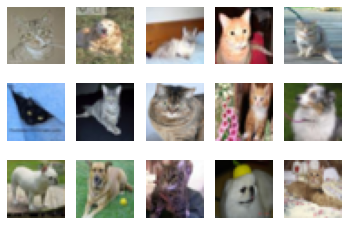

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
print("the numbers of training, validation, and test examples are ", len(train_loader), ", ",len(val_loader),", ", len(test_loader), " respectively.")

the numbers of training, validation, and test examples are  8000 ,  2000 ,  2000  respectively.


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

- We want a set of hyperparameters that result in an acceptable performance. But to determine these hyperparameters, we need validation sets to evaluate the performance of the model for different combinations of the hyper parameters and find the best model from it.
- Validation is used to track the loss of the model during training.
- Solely judging the performance using training set loss can make the model overfit to the training set and lose generality on other datasets. 


## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
param_list_small = []
paranum_small = 0
paranum_big = 0
for param in small_net.parameters():
    num = 1
    for l in param.shape:
      num = l*num
    paranum_small += num

for param in large_net.parameters():
    num = 1
    for l in param.shape:
      num = l*num
    paranum_big += num

print("there are ", paranum_small, " in small net and ", paranum_big, " in big net")

there are  386  in small net and  9705  in big net


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        default_path = '/content/gdrive/MyDrive/APS360/Lab2_results/'
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        model_path = default_path + model_path
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [ ]:
train_net(small_net, num_epochs=5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.431125, Train loss: 0.6764993209838868 |Validation err: 0.3705, Validation loss: 0.6539373937994242
Epoch 2: Train err: 0.3715, Train loss: 0.6476548590660095 |Validation err: 0.389, Validation loss: 0.661908283829689
Epoch 3: Train err: 0.355625, Train loss: 0.6378512964248657 |Validation err: 0.3465, Validation loss: 0.6263433322310448
Epoch 4: Train err: 0.3475, Train loss: 0.6260632605552673 |Validation err: 0.3495, Validation loss: 0.6224856842309237
Epoch 5: Train err: 0.337, Train loss: 0.6192369022369385 |Validation err: 0.346, Validation loss: 0.6223926171660423
Finished Training
Total time elapsed: 19.42 seconds


### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [ ]:
print("They are 64, 0.01, 30 respectively")

They are 64, 0.01, 30 respectively


### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

The files are:
- model_small_bs64_lr0.01_epoch0
- model_small_bs64_lr0.01_epoch1
- model_small_bs64_lr0.01_epoch2
- model_small_bs64_lr0.01_epoch3
- model_small_bs64_lr0.01_epoch4
- model_small_bs64_lr0.01_epoch4_train_err.csv
- model_small_bs64_lr0.01_epoch4_train_loss.csv
- model_small_bs64_lr0.01_epoch4_val_err.csv
- model_small_bs64_lr0.01_epoch4_val_loss.csv

model_small_bs64_lr0.01_epoch0~4 are the models at certain checkpoint during training, typically when one epoch of training is done.

train_err.csv and val_err.csv each stores the training and validation errors for each epoch.

train_loss.csv and val_loss.csv stores the training and validation loss for each epoch

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_net(small_net)

train_net(large_net)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.3335, Train loss: 0.611665472984314 |Validation err: 0.3385, Validation loss: 0.6225875616073608
Epoch 2: Train err: 0.3295, Train loss: 0.6058876538276672 |Validation err: 0.354, Validation loss: 0.639636317268014
Epoch 3: Train err: 0.320375, Train loss: 0.6008661460876464 |Validation err: 0.333, Validation loss: 0.6099595129489899
Epoch 4: Train err: 0.31725, Train loss: 0.5951737766265869 |Validation err: 0.3435, Validation loss: 0.6144491825252771
Epoch 5: Train err: 0.315, Train loss: 0.5903541233539581 |Validation err: 0.3275, Validation loss: 0.6080371104180813
Epoch 6: Train err: 0.303875, Train loss: 0.5864467749595642 |Validation err: 0.3325, Validation loss: 0.6069020880386233
Epoch 7: Train err: 0.306875, Train loss: 0.5816715564727784 |Validation err: 0.33, Validation loss: 0.6067112386226654
Epoch 8: Train err: 0.30175, Train loss: 0.5764448454380036 |Validation err: 0.3265,

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

err and loss for small net


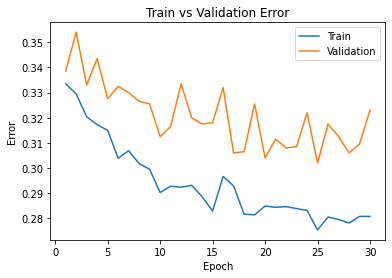

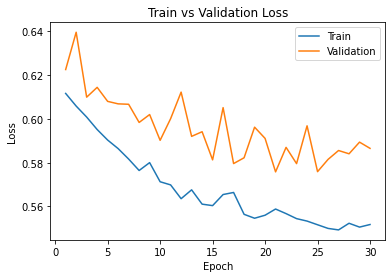

err and loss for large net


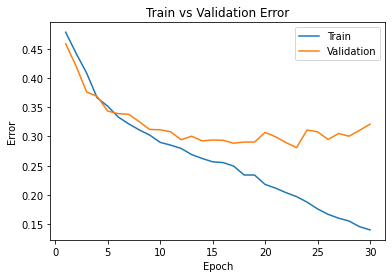

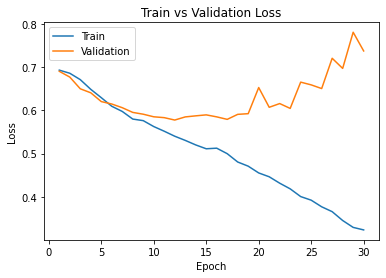

In [ ]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)
path = ('/content/gdrive/MyDrive/APS360/Lab2_results/')
model_path1 = get_model_name(small_net.name, 64, 0.01, 29)
model_path1 = path + model_path1

model_path2 = get_model_name(large_net.name, 64, 0.01, 29)
model_path2 = path + model_path2
print("err and loss for small net")
plot_training_curve(model_path1)
print("err and loss for large net")
plot_training_curve(model_path2)


### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

- large net tends to have steadier Train vs Validation Error and Loss curves, while the curves of small net are more dynamic (more ups and downs).
- Both nets have their training error and loss reducing with increasing epochs.
- The error and loss of small net and error of small exhibit a downward trend for all epochs, presenting under-fitting, signifying that more training can be done. 
- The large net loss start to rise after epochs = 15, this is the point where overfitting seems to occur. 


## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

train_net(large_net, learning_rate = 0.001)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

err and loss for lr = 0.001


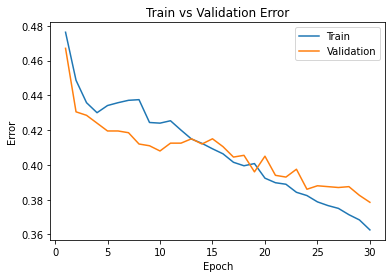

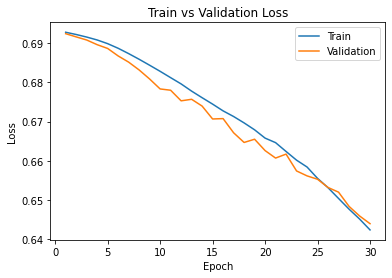

In [ ]:
path = ('/content/gdrive/MyDrive/APS360/Lab2_results/')
model_path1 = get_model_name(large_net.name, 64, 0.001, 29)
model_path1 = path + model_path1

print("err and loss for lr = 0.001")
plot_training_curve(model_path1)

- The training time with lr = 0.001 is the same as it was with lr = 0.01(roughly 127 seconds).
- Lowering the learning rate reduces the change in loss and error for each epoch. 
- Compared to the stablized loss and error curve after epochs = 15 for the large net with lr = 0.01, this one exhibits a descending trend, signifying that its loss and error can be potentially reduced further.
- Its final validation values error = 0.38 and loss = 0.645. That with lr = 0.01 have validation error = 0.34 and loss = 0.75. Current net have lower final error but higher final loss.

- The validation loss is always decreasing, meaning we avoided overfitting.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.1)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

err and loss for lr = 0.1


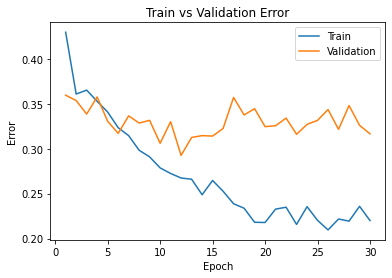

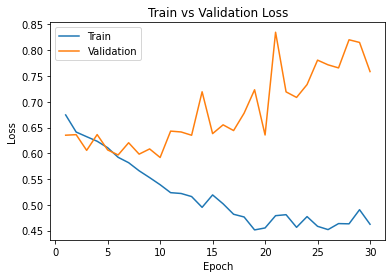

In [ ]:
path = ('/content/gdrive/MyDrive/APS360/Lab2_results/')
model_path1 = get_model_name(large_net.name, 64, 0.1, 29)
model_path1 = path + model_path1

print("err and loss for lr = 0.1")
plot_training_curve(model_path1)

- The total time with lr = 0.1 was 128.06s, while that with default parameters was 127s. The new model is faster by only roughly 1s, which is insignificant.
- lr = 0.1 leads to an error of roughly 0.34 as opposed to 0.3 with default parameters.
- The validation loss exhibits an ever-increasing trend; in contrast, the default model has a section of decreasing validation loss
- From these two observations, we conclude that we have overfitted the data by a larger extent with this model than the default one. 

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

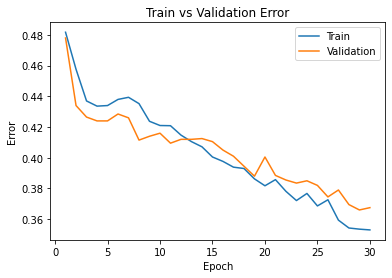

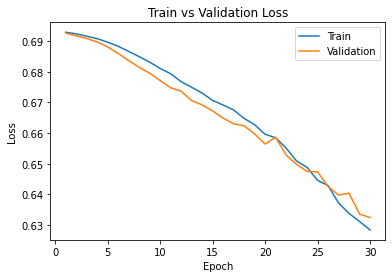

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size = 512)

path = ('/content/gdrive/MyDrive/APS360/Lab2_results/')
model_path1 = get_model_name(large_net.name, 512, 0.01, 29)
model_path1 = path + model_path1

print("err and loss for lr = 0.1")
plot_training_curve(model_path1)

- The total time elapsed with the new model is 114s, and that with default model is 128s. 
- With larger batchsize, the training time has become faster by 15s.
- Having large batch size keeps both training error and loss very low, typically around 0.001 and 0.02, whereas the validation error and loss are as high as 0.34 and 3.0 respectively. This is overfitting.
- Larger batch size means less numbers of back propogations in one epoch. This leads to some very large gradient updates, which would fit training samples particularly well, but would fit very poorly on validation samples.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

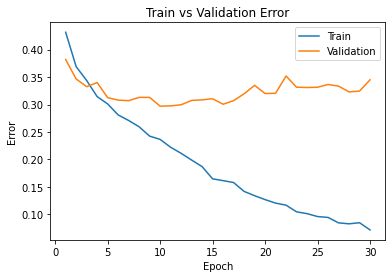

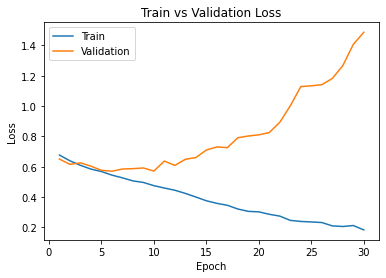

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size = 16)

path = ('/content/gdrive/MyDrive/APS360/Lab2_results/')
model_path1 = get_model_name(large_net.name, 16, 0.01, 29)
model_path1 = path + model_path1

print("err and loss for lr = 0.1")
plot_training_curve(model_path1)

- The training time with new model is 190s, which is considerably longer than the default model with 128s, by 53s. 
- Smaller batch size means more numbers of back propogations in one epoch. This means the model has been trained for excessive number of times before validation.
- Unlike with default values, this model sees an-ever increasing validation loss, meaning it has begun to overfitting at early stage.


## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

- small network
- batch_size = 64
- lr = 0.01
- epochs = 40

Small network seemed to perform better than alrge network from part 2.

Having either large or small batch size seems to have no positive effects on the validation loss,
so it is kept as 64; the same goes for learning rate. 

The validation loss seems can be reduced further with more epochs thus we change it to 40

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [ ]:
small_net = SmallNet()
train_net(small_net, num_epochs = 40)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43925, Train loss: 0.6837761998176575 |Validation err: 0.3915, Validation loss: 0.6662304494529963
Epoch 2: Train err: 0.381, Train loss: 0.6527652173042298 |Validation err: 0.3935, Validation loss: 0.6627088207751513
Epoch 3: Train err: 0.342125, Train loss: 0.6253658514022827 |Validation err: 0.335, Validation loss: 0.618512349203229
Epoch 4: Train err: 0.324, Train loss: 0.6055522425174713 |Validation err: 0.3375, Validation loss: 0.6168343275785446
Epoch 5: Train err: 0.314, Train loss: 0.5930070235729218 |Validation err: 0.32, Validation loss: 0.6096986010670662
Epoch 6: Train err: 0.299875, Train loss: 0.5810152497291565 |Validation err: 0.326, Validation loss: 0.605014132335782
Epoch 7: Train err: 0.297125, Train loss: 0.5772572119235992 |Validation err: 0.332, Validation loss: 0.6006468189880252
Epoch 8: Train err: 0.293625, Train loss: 0.5692502632141113 |Validation err: 0.3085, V

err and loss for lr = 0.1


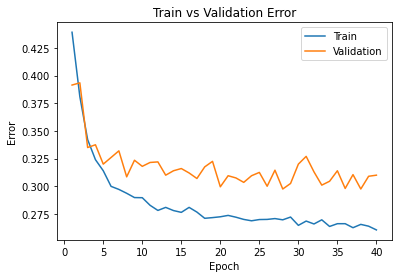

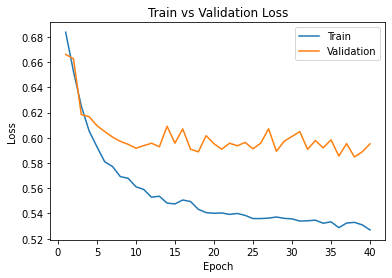

In [ ]:

path = ('/content/gdrive/MyDrive/APS360/Lab2_results/')
model_path1 = get_model_name(small_net.name, 64, 0.01, 39)
model_path1 = path + model_path1

print("err and loss for lr = 0.1")
plot_training_curve(model_path1)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.


- small network
- batch_size = 128
- lr = 0.02
- epochs = 30

The suggested parameters in part a did not result in significant improvement compared to the default model. 

Smaller batch size also caused longer training time, but did not result in performance improvement

All test and validation error/loss curves have flattened out, meaning it has had enough training. Thus I suppose having more epochs or less batch size would not make it any better. 

Now we try to adjust the learning rate and batch size, and see how it does. 

We do this because learning rate is infact a very influential hyperparameter in training but we have not tried to change it by little magnitude. We enlarge batch size because it seemed to have little effect on performance but it is a major factor in training time.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [ ]:
small_net = SmallNet()
train_net(small_net,learning_rate=0.02, num_epochs = 30, batch_size=128 )

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.428875, Train loss: 0.6754486343217274 |Validation err: 0.3745, Validation loss: 0.6566603854298592
Epoch 2: Train err: 0.37275, Train loss: 0.6457194004740033 |Validation err: 0.4225, Validation loss: 0.6995023302733898
Epoch 3: Train err: 0.352375, Train loss: 0.6311412283352443 |Validation err: 0.342, Validation loss: 0.6228309348225594
Epoch 4: Train err: 0.336125, Train loss: 0.6087562318832155 |Validation err: 0.3295, Validation loss: 0.6151838041841984
Epoch 5: Train err: 0.32175, Train loss: 0.6017656685814025 |Validation err: 0.3335, Validation loss: 0.6142406053841114
Epoch 6: Train err: 0.311, Train loss: 0.5889608046365162 |Validation err: 0.333, Validation loss: 0.6092728786170483
Epoch 7: Train err: 0.31225, Train loss: 0.5875816439825391 |Validation err: 0.328, Validation loss: 0.6080592684447765
Epoch 8: Train err: 0.310625, Train loss: 0.5834503694186135 |Validation err: 0

err and loss for lr = 0.1


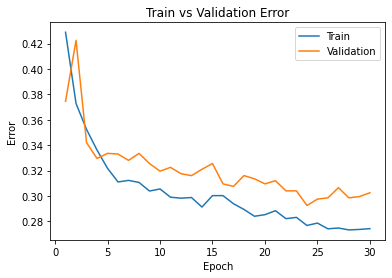

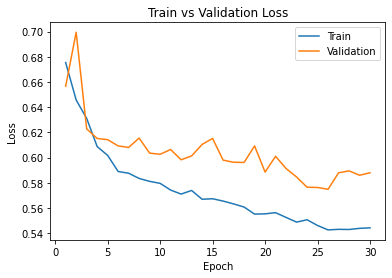

In [ ]:
path = ('/content/gdrive/MyDrive/APS360/Lab2_results/')
model_path1 = get_model_name(small_net.name, 128, 0.02, 29)
model_path1 = path + model_path1

print("err and loss for lr = 0.1")
plot_training_curve(model_path1)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = SmallNet()
path = ('/content/gdrive/MyDrive/APS360/Lab2_results/')
model_path = get_model_name(net.name, batch_size=128, learning_rate=0.02, epoch=24)
model_path = path + model_path
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).


ANS: From part 3 e, we acquired the lowest validation error of 0.292 for at epoch = 25.
This is the lowest error and loss achieved out of all tests we have done. It is also shown that the model at epoch = 25 performs best.


### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=128)
criterion = nn.BCEWithLogitsLoss()
validation_err, validation_loss= evaluate(net, val_loader, criterion)
training_err, training_loss = evaluate(net, train_loader, criterion)
test_err, test_loss = evaluate(net, test_loader, criterion)
print("Validation Error: {}, Validation Loss:{}".format(validation_err, validation_loss))
print("Training Error: {}, Training Loss:{}".format(training_err, training_loss))
print("Test Error: {}, Test Loss:{}".format(test_err, test_loss))


Files already downloaded and verified
Files already downloaded and verified
Validation Error: 0.2975, Validation Loss:0.5779120735824108
Training Error: 0.268375, Training Loss:0.5363621494126698
Test Error: 0.3045, Test Loss:0.5735595636069775


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

ANS: The test error = 0.2815 is in fact lower than the validation error = 0.295 in my case. We expect the test error to be higher because the validation sets have participated in training and determining the hyperparameters of the network, so the performance of the model we anticipated during training was based on both the training and validation sets. We would not expect the model to perform better with datasets other than training and validation because there is simply no way a model could perform worse on its given samples than on the entire population. The test set, which the model has never seen before, is part of the general population. Therefore, we expect the test error to be higher than the validation error.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

ANS: We use test set to acquire a final, unbiased performance evaluation of our finalized model. We used training and validation sets to determine a set of hyperparameters that result in optimal performance, but we cannot guarentee that it is optimal for the general population. We therefore would like to feed the test set, which the model has never seen before, to verify if our model is in fact good enough for general population of data.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4095, Train loss: 0.6664599000461517 |Validation err: 0.391, Validation loss: 0.6520312987267971
Epoch 2: Train err: 0.36475, Train loss: 0.6363911392196776 |Validation err: 0.396, Validation loss: 0.657254058867693
Epoch 3: Train err: 0.35275, Train loss: 0.6262596694249956 |Validation err: 0.383, Validation loss: 0.6458991691470146
Epoch 4: Train err: 0.337625, Train loss: 0.6112983851205736 |Validation err: 0.407, Validation loss: 0.6689145527780056
Epoch 5: Train err: 0.32725, Train loss: 0.5983936833956885 |Validation err: 0.3825, Validation loss: 0.6438199579715729
Epoch 6: Train err: 0.31075, Train loss: 0.5860570990850055 |Validation err: 0.3805, Validation loss: 0.6501362510025501
Epoch 7: Train err: 0.298125, Train loss: 0.569608530827931 |Validation err: 0.3895, Validation loss: 0.6710918582975864
Epoch 8: Train err: 0.286875, Train loss: 0.5590661641151186 |Validation err: 0.37

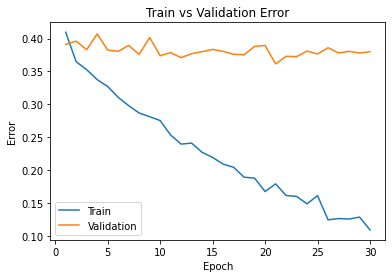

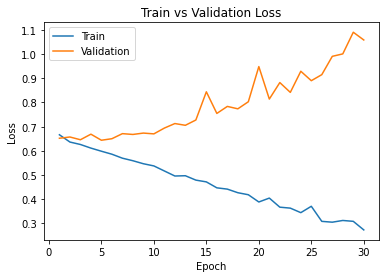

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.name = "Pigeon"
        self.layer1 = nn.Linear(32 * 32 * 3, 30)
        self.layer2 = nn.Linear(30, 1)
    def forward(self, img):
        flattened = img.view(-1, 32 * 32 * 3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2

pigeon = Pigeon()

train_net(pigeon, batch_size=128, learning_rate=0.02)
path = ('/content/gdrive/MyDrive/APS360/Lab2_results/')
model_path_pigeon = get_model_name(pigeon.name, batch_size=128, learning_rate=0.02, epoch=29)
model_path_pigeon = path + model_path_pigeon
plot_training_curve(model_path_pigeon)

In [ ]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=128)
criterion = nn.BCEWithLogitsLoss()
validation_err, validation_loss= evaluate(pigeon, val_loader, criterion)
training_err, training_loss = evaluate(pigeon, train_loader, criterion)
test_err, test_loss = evaluate(pigeon, test_loader, criterion)
print("Validation Error: {}, Validation Loss:{}".format(validation_err, validation_loss))
print("Training Error: {}, Training Loss:{}".format(training_err, training_loss))
print("Test Error: {}, Test Loss:{}".format(test_err, test_loss))

Files already downloaded and verified
Files already downloaded and verified
Validation Error: 0.38, Validation Loss:1.0606449618935585
Training Error: 0.100375, Training Loss:0.2521362652381261
Test Error: 0.376, Test Loss:1.077420450747013


The ANN yeilds validation error = 0.38, validation loss = 1.06, test error = 0.376, test loss = 1.077.

As compared to the CNN model with test error = 0.2815, the ANN model performs much worse